In [252]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import impnb
import Data_processing as dp
import ToyQ2
from scipy.optimize import minimize
from functools import partial
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

git_data='/cndd/hop006/Github/RewardReversalPorject/Data/epoched_eeg'

behavior_log_path='/cndd/hop006/Github/RewardReversalPorject/BehaviorLog/'
Logs=pd.read_pickle(git_data+'/26to38behaviors.pickle')
rat_2_anal=[33, 34, 35, 36, 37, 38, 26, 28, 29, 30, 31]

In [272]:
def myllNEG(action_log,reward_log,params): #returns sum of negative likelihood
    n=len(mya)
    alphaG=params[0]
    alphaL=params[1]
    beta=params[2]
    initQ=[params[3],params[4]]
    
    Q=np.tile(initQ,(n,1))
#     Q=np.zeros((n,2))

    ll=np.zeros((n,1))
    PE=np.zeros((n,1))
    q=np.zeros((n,1))
    for i in range(n):
        choice=int(action_log[i]-1)
        if reward_log[i]:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaG*reward_log[i]
        else:
            Q[i,choice]=(1-alphaL)*Q[i-1,choice]+alphaL*reward_log[i]
            
        Q[i,1-choice]=Q[i-1,1-choice]
        q[i]=Q[i,choice]
#         ll[i]=-int(action_log[i]==1)*np.log(1+np.exp(beta*(Q[i,0]-Q[i,1]))) + \
#         -int(action_log[i]==2)*np.log(1+np.exp(-beta*(Q[i,0]-Q[i,1])))# test this

        ll[i]=int(action_log[i]==1)*np.log(0.5+0.5*np.tanh(beta*(Q[i,0]-Q[i,1]))) + \
        int(action_log[i]==2)*np.log(0.5+0.5*np.tanh(beta*(Q[i,0]-Q[i,1])))
        
#         print(i,ll[i],Q[i],action_log[i],reward_log[i])
        PE[i]=Q[i,choice]-reward_log[i]
    return -np.sum(ll,axis=0)

def myll_log(action_log,reward_log,params): # returns log likelihood
    n=len(action_log)
    alphaG=params[0] 
    alphaL=params[1]
    beta=params[2]
    initQ=[params[3],params[4]]
    
    
    Q=np.tile(initQ,(n,1))
#     Q=np.zeros((n,2)) #zero init
#     Q=np.full((n,2),0.5)
    ll=np.zeros((n,1))
    PE=np.zeros((n,1))
    q=np.zeros((n,1))
    for i in range(n):
        choice=int(action_log[i]-1)
        if reward_log[i]:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaG*reward_log[i]
        else:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaL*reward_log[i]
            
        Q[i,1-choice]=Q[i-1,1-choice]
        q[i]=Q[i,choice]
#         ll[i]=-int(action_log[i]==1)*np.log(1+np.exp(beta*(Q[i,0]-Q[i,1]))) + \
#         -int(action_log[i]==2)*np.log(1+np.exp(-beta*(Q[i,0]-Q[i,1])))# test this
                                           
        ll[i]=int(action_log[i]==1)*np.log(0.5+0.5*np.tanh(beta*(Q[i,0]-Q[i,1]))) + \
        int(action_log[i]==2)*np.log(0.5+0.5*np.tanh(beta*(Q[i,0]-Q[i,1])))
        print(ll)
#         print(i,ll[i],Q[i],action_log[i],reward_log[i])
        PE[i]=Q[i,choice]-reward_log[i]
    return ll,PE,q,Q

def MLE(action_log,reward_log,params0):
    b1=(0.01,0.8)
    b2=(0.1,40)
    b3=(0,1)
    bnds=(b1,b1,b2,b3,b3)
    cur_myll=partial(myllNEG,mya,myr)
    sol=minimize(cur_myll,params0,method='SLSQP',bounds=bnds)
    return sol

def grid_alphas(action_log,reward_log,beta,Q0,plot=False):
    alphaGs=np.linspace(0.01,0.8,30)
    alphaLs=np.linspace(0.01,0.8,30)
    betas=np.linspace(0.1,40,30)
    Gs,Ls=np.meshgrid(alphaGs,alphaLs,indexing='xy')
    Z=np.zeros_like(Gs)
    for i in range(30):
        for j in range(30):
            param=[Gs[j,i],Ls[j,i],beta,Q0[0],Q0[1]]
            ll=myllNEG(mya,myr,param)
            Z[j,i]=ll
    if plot:
        plt.title('Negative Log likelihood')
        plt.xlabel('alphaG')
        plt.ylabel('alphaL')
        plt.contourf(Gs,Ls,Z,cmap='jet')
        plt.colorbar()
        plt.show()
        

# Demo: Negative log likelihood 

In [273]:
rat=33
day=0
flag='rat_'+str(rat)+'day_'+str(day)
mya=Logs.loc[flag+'action'][0]
myr=Logs.loc[flag+'reward'][0]

n=np.min(np.array([mya.size,myr.size]))

mya=mya[:n]
myr=myr[:n]

# sol=MLE(mya[:n],myr[:n],real_params)
# mparams=sol['x']
# print(sol['success'])
# ll,PE,q,Q=myll_log(mya[:n],myr[:n],mparams);
# plt.plot(PE)
# plt.title(mparams)

In [274]:
interact(grid_alphas,action_log=fixed(mya),reward_log=fixed(myr),beta=widgets.IntSlider(min=1, max=30, step=1, value=1),Q0=fixed(Q0),plot=fixed(True))

interactive(children=(IntSlider(value=1, description='beta', max=30, min=1), Output()), _dom_classes=('widget-…

<function __main__.grid_alphas(action_log, reward_log, beta, Q0, plot=False)>

In [275]:
interact(grid_alphas,action_log=fixed(mya),reward_log=fixed(myr),beta=widgets.IntSlider(min=1, max=30, step=1, value=1),Q0=fixed(Q0),plot=fixed(True))

interactive(children=(IntSlider(value=1, description='beta', max=30, min=1), Output()), _dom_classes=('widget-…

<function __main__.grid_alphas(action_log, reward_log, beta, Q0, plot=False)>

# Plot all rat profiles

33


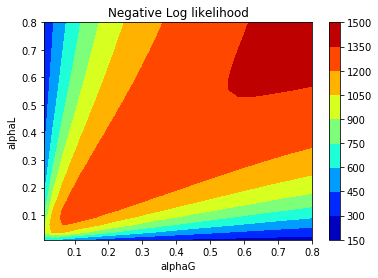

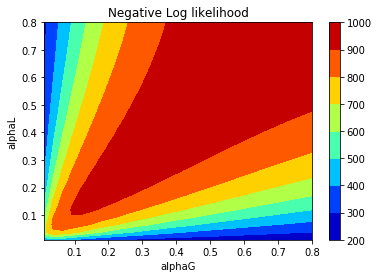

34


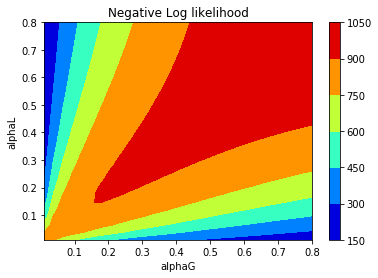

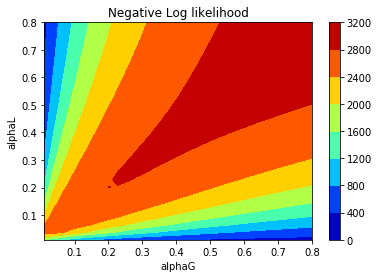

35


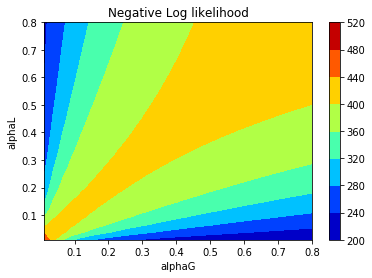

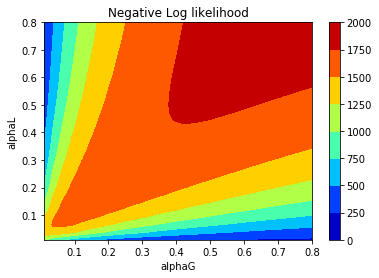

36


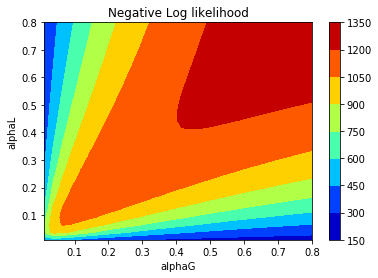

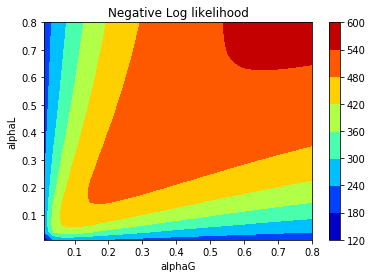

37


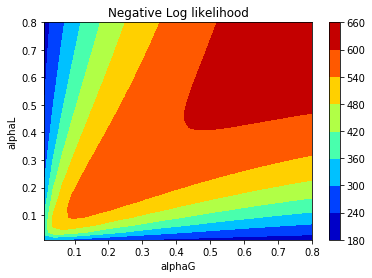

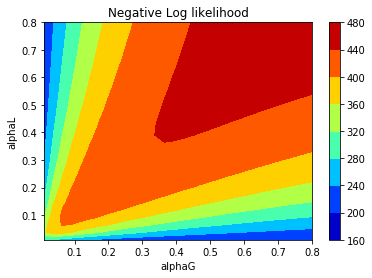

38


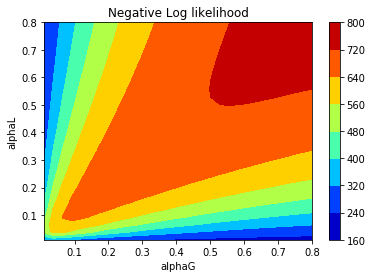

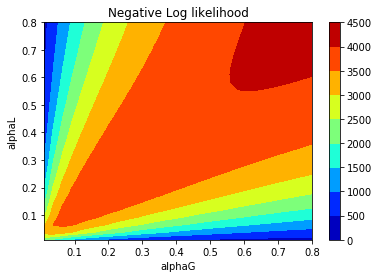

26


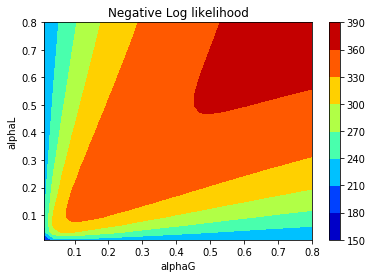

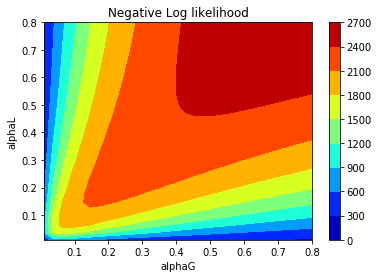

28


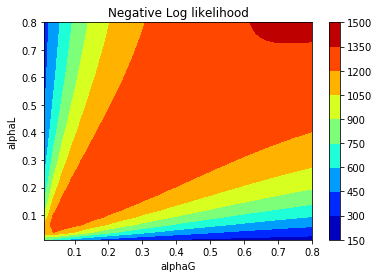

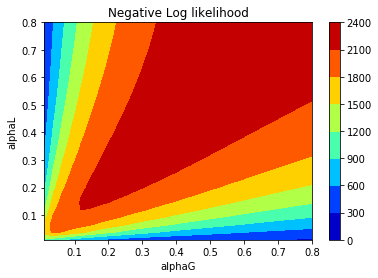

29


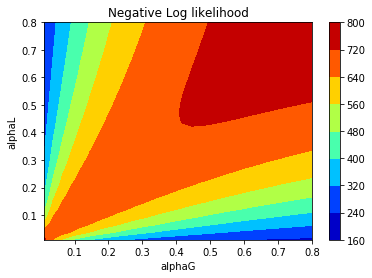

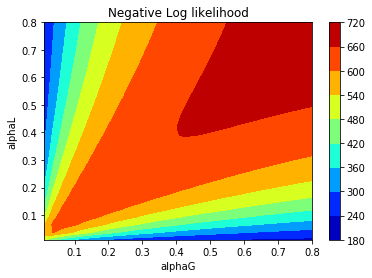

30


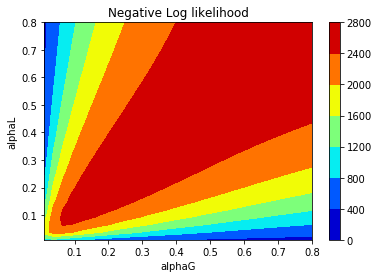

/home/AD/hop006/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/home/AD/hop006/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/home/AD/hop006/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/home/AD/hop006/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


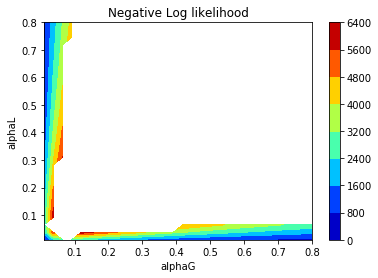

31


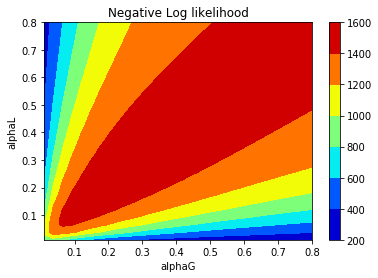

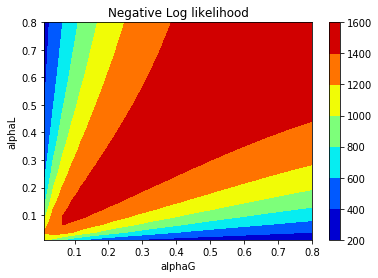

In [276]:
count=1
for rat in rat_2_anal:
    print(rat)
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        plt.figure(count)
        count+=1
        beta=PELogs[flag+'params'][2]
        Q0=PELogs[flag+'params'][3:]
        mya=Logs.loc[flag+'action'][0]
        myr=Logs.loc[flag+'reward'][0]
        grid_alphas(mya,myr,beta,Q0,plot=fixed(True))

In [223]:
real_params #alphaG,alphaL,beta,Qa,Qb

[0.3, 0.3, 1, 0.5, 0.5]

In [148]:
def gridMLE(action_log,reward_log,params0):
    n=len(mya)
    alphaG=params0[0]
    alphaL=params0[1]
    beta=params0[2]
    initQ=[params0[3],params0[4]]
    b

In [149]:
gridMLE(mya,myr,real_params)

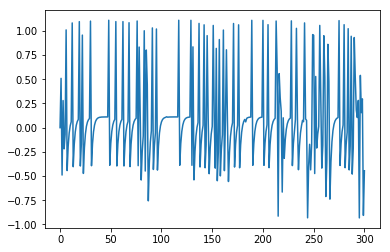

In [141]:
real_params=[0.5,0.5,4,0.1,0.11]
env=ToyQ2.toyQ_2choice()
rat1=dp.Rat(None,*real_params[:-1],init_Q=np.array([0.51,0.51]),sim=True)
env,rat1=dp.train_rat(env,rat1,300,sim=True)
plt.plot(rat1.PElog)
mya=rat1.choice_Log
myr=rat1.obsLog

In [142]:
sol=MLE(mya,myr,real_params)
sol

     fun: 96.35803743563622
     jac: array([ 3.96806093e+03,  4.33544847e+02, -1.06801987e-02, -2.02249557e+02,
        1.67856216e-01])
 message: 'Positive directional derivative for linesearch'
    nfev: 229
     nit: 34
    njev: 30
  status: 8
 success: False
       x: array([1.00000000e-02, 1.00000000e-02, 1.97930351e+01, 1.00000000e+00,
       7.36986189e-01])

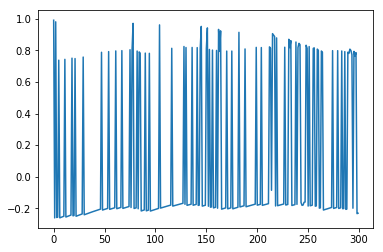

In [143]:
mparams=sol['x']
ll,PE,q,Q=myll_log(mya,myr,mparams)
plt.plot(PE)

# Get all PE logs

In [144]:
real_params=[0.3,0.3,1,0.5,0.5] # initial input to the MLE

33
True
True
34
True
True
35
True
True
36
True
True
37
True
True
38
True
True
26
True
True
28
True
True
29
True
True
30
True
True
31
True
True


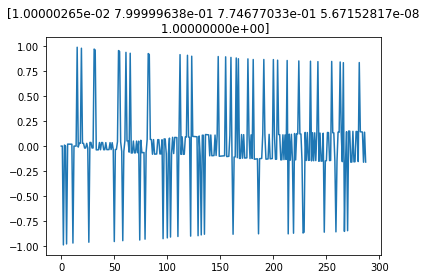

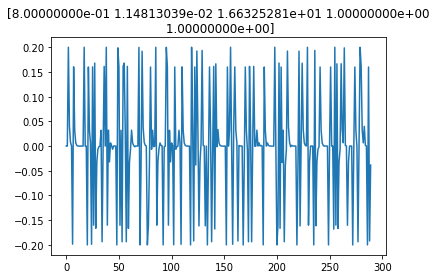

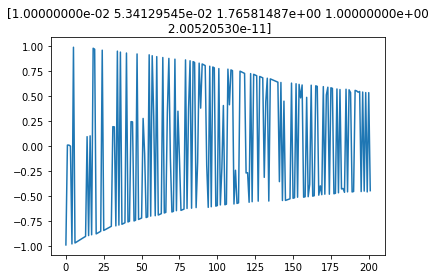

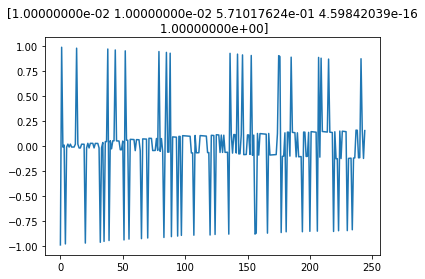

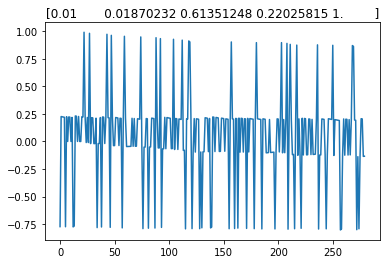

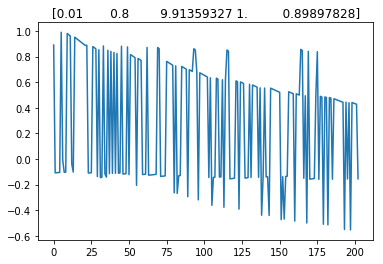

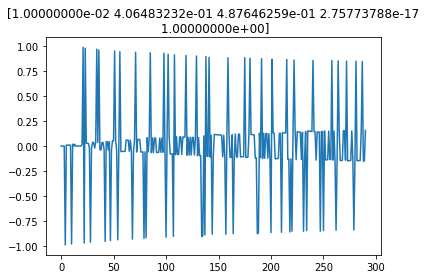

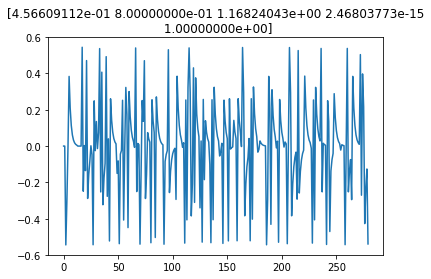

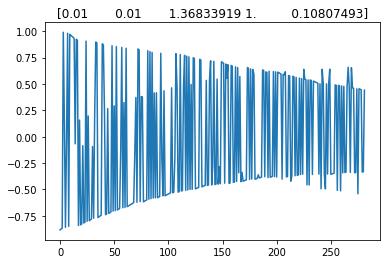

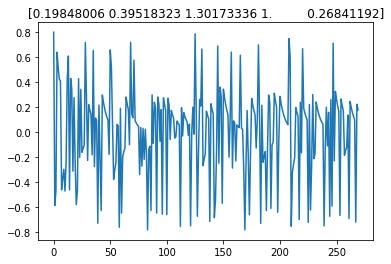

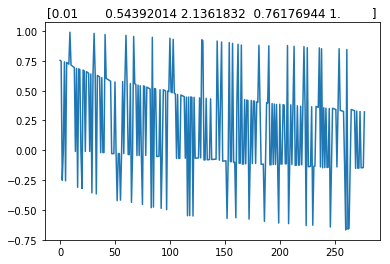

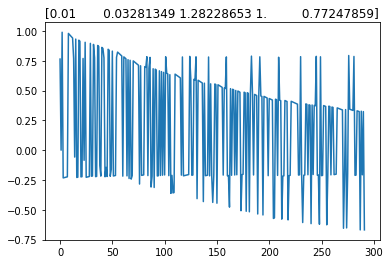

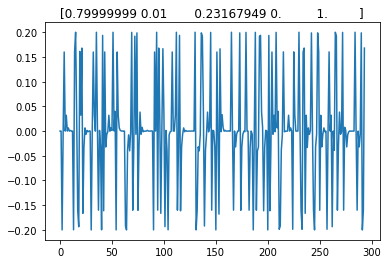

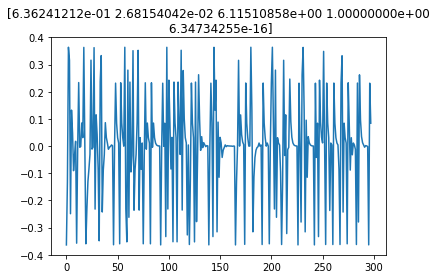

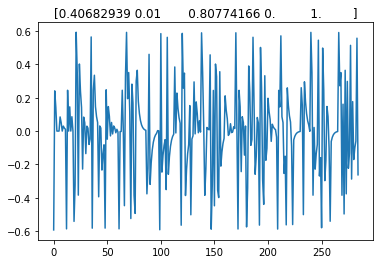

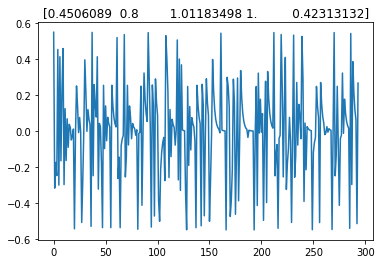

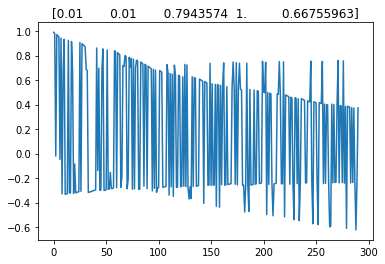

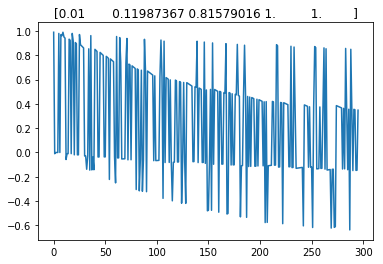

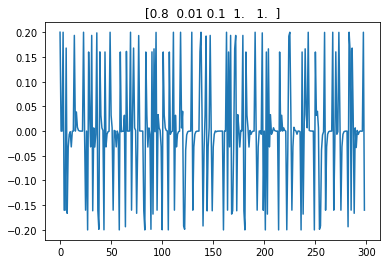

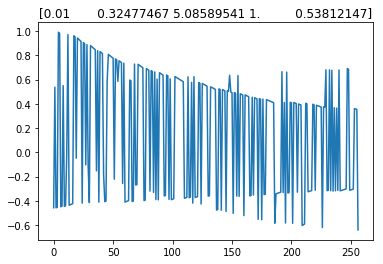

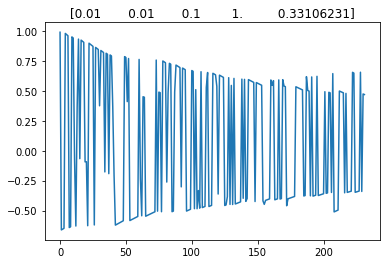

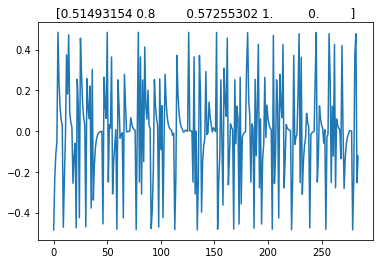

In [137]:
days=2
count=1
tarPELogs={}
filflag=False

for rat in rat_2_anal:
    print(rat)
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        plt.figure(count)
        count+=1
        
        mya=Logs.loc[flag+'action'][0]
        myr=Logs.loc[flag+'reward'][0]
        
        n=np.min(np.array([mya.size,myr.size]))
        
        mya=mya[:n]
        myr=myr[:n]
        
        sol=MLE(mya[:n],myr[:n],real_params)
        mparams=sol['x']
        print(sol['success'])
        ll,PE,q,Q=myll_log(mya[:n],myr[:n],mparams)
        plt.plot(PE)
        plt.title(mparams)
        
        tarPELogs['rat_'+str(rat)+'day_'+str(day)]=PE
        tarPELogs['rat_'+str(rat)+'day_'+str(day)+'Q']=Q
        tarPELogs['rat_'+str(rat)+'day_'+str(day)+'params']=mparams

33
True
True
34
True
True
35
True
True
36
True
True
37
True
True
38
True
True
26
True
True
28
True
True
29
True
True
30
True
True
31
True
True


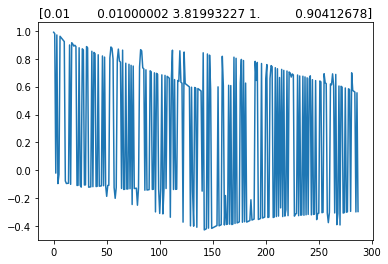

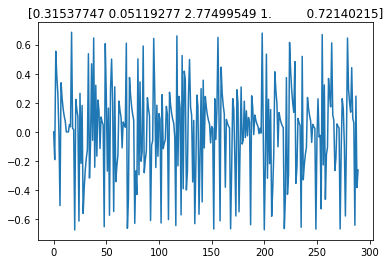

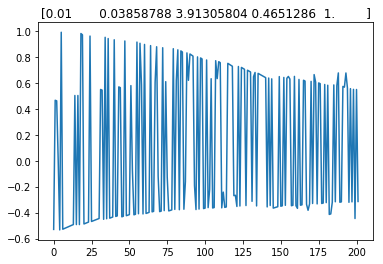

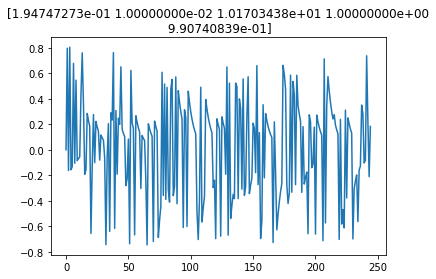

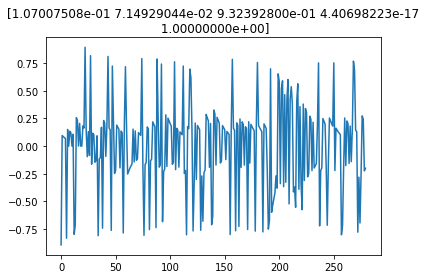

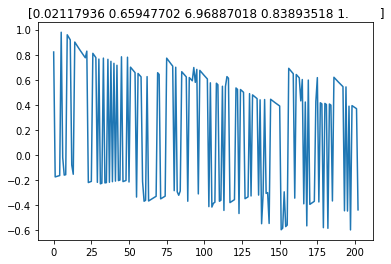

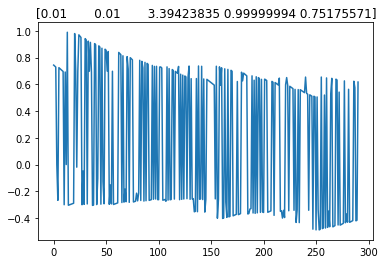

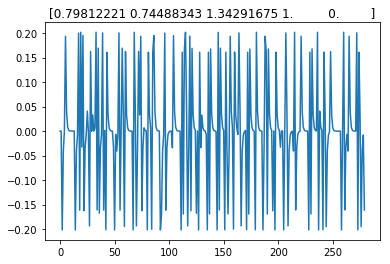

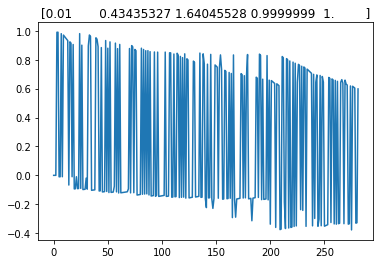

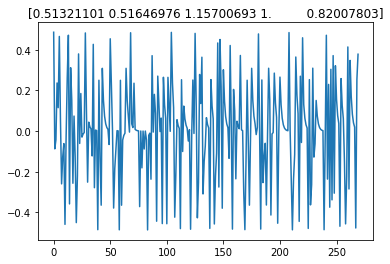

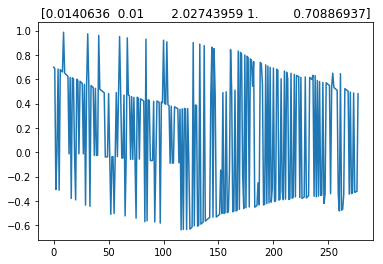

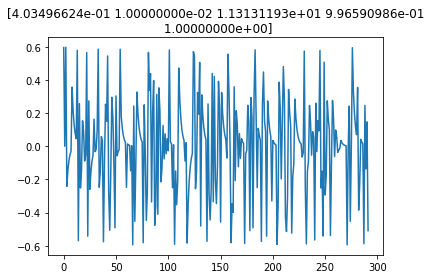

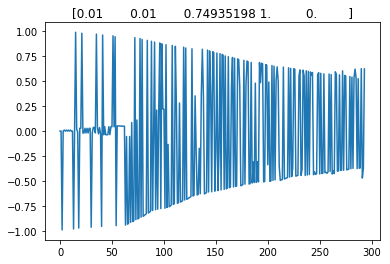

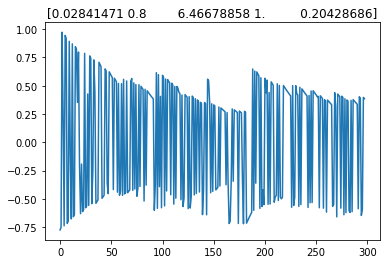

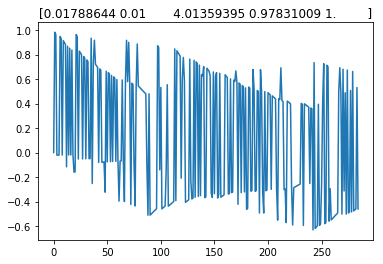

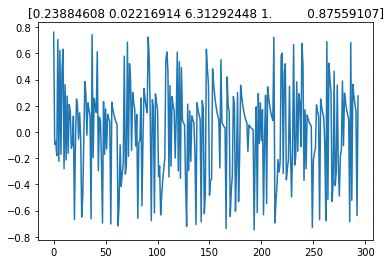

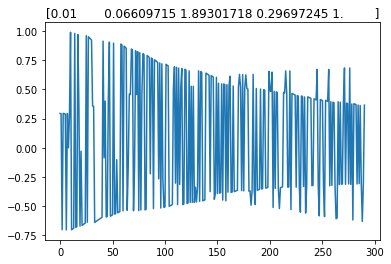

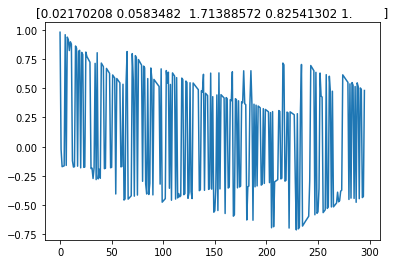

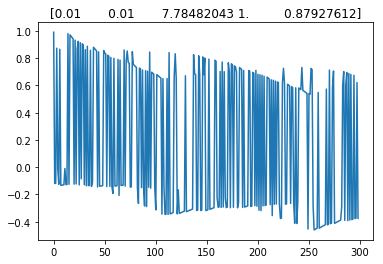

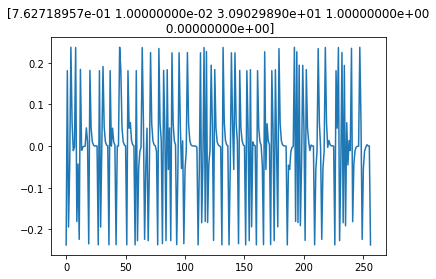

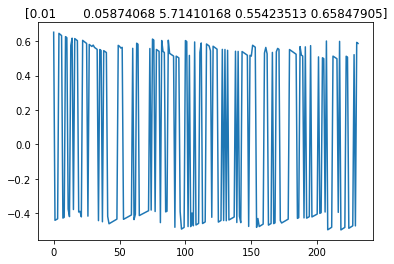

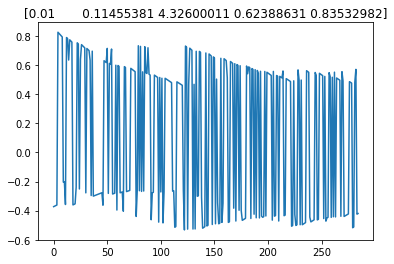

In [133]:
days=2
count=1
PELogs={}
filflag=False

for rat in rat_2_anal:
    print(rat)
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        plt.figure(count)
        count+=1
        
        mya=Logs.loc[flag+'sideaction'][0]
        myr=Logs.loc[flag+'reward'][0]
        
        n=np.min(np.array([mya.size,myr.size]))
        
        mya=mya[:n]
        myr=myr[:n]
        
        sol=MLE(mya[:n],myr[:n],real_params)
        mparams=sol['x']
        print(sol['success'])
        ll,PE,q,Q=myll_log(mya[:n],myr[:n],mparams)
        plt.plot(PE)
        plt.title(mparams)
        
        PELogs['rat_'+str(rat)+'day_'+str(day)]=PE
        PELogs['rat_'+str(rat)+'day_'+str(day)+'Q']=Q
        PELogs['rat_'+str(rat)+'day_'+str(day)+'params']=mparams

In [125]:
PElog_df=pd.Series(PELogs).to_frame('ColumnName')
PElog_df.to_pickle(behavior_log_path+'rat26to38PElog.pkl')

In [248]:
tarPElog_df=pd.Series(tarPELogs).to_frame('ColumnName')
tarPElog_df.to_pickle(behavior_log_path+'rat26to38tarPElog.pkl')